<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Mask_and_Distance_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask and Social distancing Detection 

In [1]:
import numpy as np 
import pandas as pd 
import cv2
from scipy.spatial import distance

In [ ]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

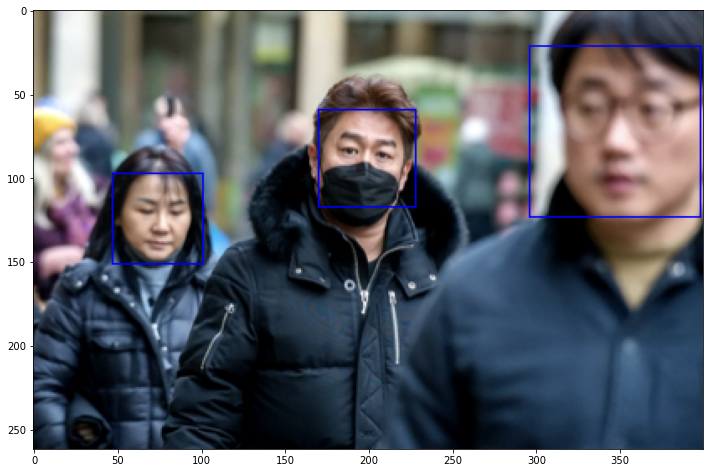

In [ ]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [ ]:
MIN_DISTANCE = 130

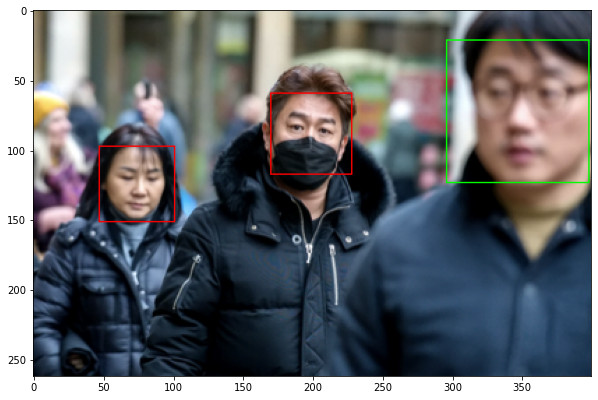

In [ ]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red box shows violation of social distancing.

### Using VGG19 for mask detection


In [ ]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Load train and test set
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Building VGG19 transfer learning model.

In [ ]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
9/9 [==============================] - 7s 418ms/step - loss: 0.7079 - accuracy: 0.5824
Epoch 2/20
9/9 [==============================] - 3s 359ms/step - loss: 0.2847 - accuracy: 0.8949
Epoch 3/20
9/9 [==============================] - 4s 401ms/step - loss: 0.1781 - accuracy: 0.9291
Epoch 4/20
9/9 [==============================] - 3s 344ms/step - loss: 0.1914 - accuracy: 0.9195
Epoch 5/20
9/9 [==============================] - 3s 323ms/step - loss: 0.1215 - accuracy: 0.9567
Epoch 6/20
9/9 [==============================] - 3s 348ms/step - loss: 0.1394 - accuracy: 0.9582
Epoch 7/20
9/9 [==============================] - 3s 356ms/step - loss: 0.0867 - accuracy: 0.9802
Epoch 8/20
9/9 [==============================] - 3s 335ms/step - loss: 0.1350 - accuracy: 0.9531
Epoch 9/20
9/9 [==============================] - 3s 333ms/step - loss: 0.1082 - accuracy: 0.9631
Epoch 10/20
9/9 [==============================] - 3s 309ms/step - loss: 0.1007 - accuracy: 0.9602
Epoch 11/20
9/9 [==

In [ ]:
model.evaluate_generator(test_generator)

[0.06896067410707474, 0.9800000190734863]

Our modela achieved 98% accuracy on test data.

### Testing the model on the test data

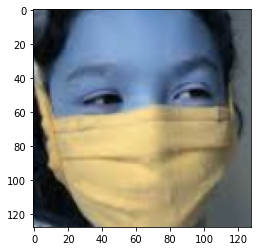

In [ ]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [ ]:
model.predict(sample_mask_img)

array([[0.9832575 , 0.13589811]], dtype=float32)

The model is able to classify if the person is wearing a mask or not.

### Save the model.

In [ ]:
model.save('masknet.h5')

### Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

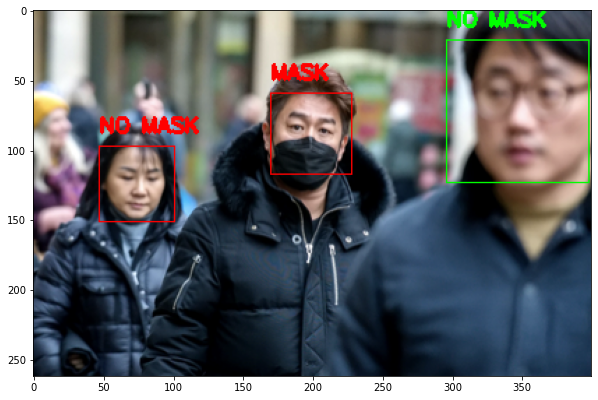

In [ ]:
if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

#### Red boxes shows violation of social distancing.